In [2]:
import env
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Activation, LeakyReLU, BatchNormalization, Input, AveragePooling2D
from keras.utils import np_utils
from sklearn.model_selection import train_test_split 
from tensorflow.keras.optimizers import SGD
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
print("Imported")


Imported


In [3]:
print("START123")
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3))
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.3
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

START123


In [4]:
X = np.load(env.FEATURES_PATH)
Y = np.load(env.LABELS_PATH)
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.01)

print("LOADED")
print(x_train.shape)
print(y_train.shape)

LOADED
(990, 224, 224, 3)
(990, 5)


In [5]:
#vgg16
print("preparing model...")
base = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
#weights="imagenet",
new_model = base.output
new_model = MaxPool2D(pool_size=(7, 7))(new_model)
new_model = Flatten(name="flatten")(new_model)
new_model = Dense(256)(new_model)
new_model = LeakyReLU(0.2)(new_model)
new_model = Dropout(0.5)(new_model)
new_model = Dense(5, activation="softmax")(new_model)
new_model = Activation('softmax')(new_model)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=base.input, outputs=new_model)

#Make the pre trained layers untrainable
for layer in base.layers:
    layer.trainable = False
print("DONE")

preparing model...
DONE


In [6]:
epochs = 50
learning_rate = 0.001
decay_rate = learning_rate / epochs
momentum = 0.2
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
adam = tf.keras.optimizers.Adam(lr = learning_rate, decay=decay_rate)
model.compile(loss='kullback_leibler_divergence', optimizer=sgd, metrics=['accuracy'])
#kullback_leibler_divergence
#categorical_crossentropy
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

C:\Users\95kes\python\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
C:\Users\95kes\python\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1,patience=10)
trained = model.fit(x_train, y_train, batch_size=32, epochs=epochs, validation_split = 0.2, shuffle = True,callbacks=[es])

Epoch 1/50
25/25 [==============================] - 15s 332ms/step - loss: 1.6825 - accuracy: 0.1250 - val_loss: 1.6372 - val_accuracy: 0.1364
Epoch 2/50
25/25 [==============================] - 4s 153ms/step - loss: 1.5924 - accuracy: 0.2538 - val_loss: 1.4952 - val_accuracy: 0.5707
Epoch 3/50
25/25 [==============================] - 4s 151ms/step - loss: 1.4606 - accuracy: 0.4710 - val_loss: 1.3637 - val_accuracy: 0.6010
Epoch 4/50
25/25 [==============================] - 4s 152ms/step - loss: 1.3631 - accuracy: 0.5896 - val_loss: 1.3250 - val_accuracy: 0.6010
Epoch 5/50
25/25 [==============================] - 4s 151ms/step - loss: 1.3212 - accuracy: 0.6212 - val_loss: 1.3147 - val_accuracy: 0.6010
Epoch 6/50
25/25 [==============================] - 4s 152ms/step - loss: 1.2952 - accuracy: 0.6326 - val_loss: 1.3111 - val_accuracy: 0.6010
Epoch 7/50
25/25 [==============================] - 4s 152ms/step - loss: 1.2937 - accuracy: 0.6288 - val_loss: 1.3091 - val_accuracy: 0.6010
Epoch

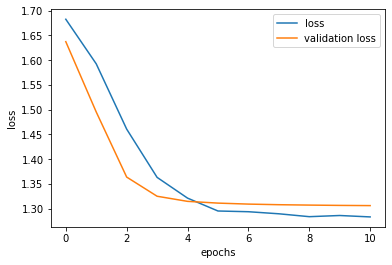

In [14]:
plt.plot(trained.history['loss'], label="loss")
plt.plot(trained.history['val_loss'], label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

No handles with labels found to put in legend.


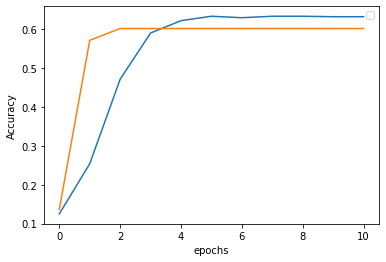

In [15]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend()

In [16]:
#with tf.device('/cpu:0'):
# x_test = np.load(f"{base_path}x_test.npy")
# y_test = np.load(f"{base_path}y_test.npy")
print(x_test.shape)
print(y_test.shape)
print(model.evaluate(x=x_test, y=y_test))
print("DONE")

(10, 224, 224, 3)
(10, 5)
1/1 [==============================] - 0s 339ms/step - loss: 1.3062 - accuracy: 0.6000
[1.3061593770980835, 0.6000000238418579]
DONE


In [17]:
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5) 
y_pred

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

In [18]:
from sklearn.metrics import multilabel_confusion_matrix
score = multilabel_confusion_matrix(
    y_test, 
    y_pred)
score

array([[[ 9,  0],
        [ 1,  0]],

       [[ 9,  0],
        [ 1,  0]],

       [[10,  0],
        [ 0,  0]],

       [[ 4,  0],
        [ 6,  0]],

       [[ 8,  0],
        [ 2,  0]]], dtype=int64)

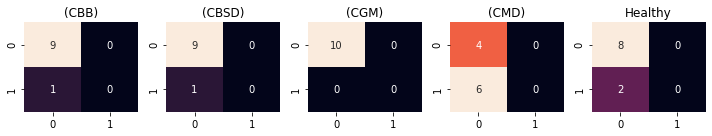

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
sns.heatmap(score[0], annot=True, fmt="d", cbar=False,ax=axes[0])
axes[0].set_title('(CBB)')
sns.heatmap(score[1], annot=True, fmt="d", cbar=False,ax=axes[1])
axes[1].set_title('(CBSD)')
sns.heatmap(score[2], annot=True, fmt="d", cbar=False,ax=axes[2])
axes[2].set_title('(CGM)')
sns.heatmap(score[3], annot=True, fmt="d", cbar=False,ax=axes[3])
axes[3].set_title('(CMD)')
sns.heatmap(score[4], annot=True, fmt="d", cbar=False,ax=axes[4])
axes[4].set_title('Healthy')
fig.tight_layout()
plt.show()